# PCA Analysis - As a time series

We have seen that PCA analysis yields some insight but I have some further questions.

**Time series visualise**

Can we use the PCA analysis to visualise *changing* patterns in the behaviour.

In [1]:
import datetime
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from IPython.core.display import Javascript
from IPython.display import display
from IPython.display import HTML

from PedestrianDataImporter import getHourlyCounts
from Imputation import imputeMissing
from DataFrameManipulations import countsLongToWideHourly

## Data importing and some manipulations

We want to see if we can use the PCA with the Melbourne data to view changes in the usage behaviour.
Lets first import the Melbourne data and cut out a time window in 2018 and 2019 to perform the PCA analysis with. We will then use those PCA components to visualise the entire dataset.

In [2]:
df_counts,df_locations = getHourlyCounts['Melbourne']()
df_counts = imputeMissing(df_counts)

start_date = datetime.datetime(2018,1,1)
end_date   = datetime.datetime(2020,1,1)
cut = (df_counts['DateTime'] >  start_date) & (df_counts['DateTime'] < end_date ) 
df_cut = df_counts.loc[cut]

# The reduced dataset.
df1 = df_counts.loc[cut][['DateTime','LocationName','HourlyCount']]
df1 = df1.dropna(axis='columns',how='any')

# The "entire" dataset
df2 = df_counts[['DateTime','LocationName','HourlyCount']]
df2 = df2.dropna(axis='columns',how='any')

Loading Melbourne_stored.pkl
Todo: Imputation


In [3]:
df_wide = countsLongToWideHourly(df1)
df_wide = df_wide.dropna(axis='columns',how='any')
sites_complete = df_wide.columns.tolist()

We want vectors that represent a days worth of counts or a weeks worth of counts.
While we at it lets also take just weekdays and weekends, we have seen that these have different behaviours

In [4]:
def includeAdditionalTimefields(df):
    df['Day']  = df['DateTime'].dt.dayofweek  # 0: Monday, 1: Tuesday, ..., 6: Sunday
    df['Hour'] = df['DateTime'].dt.hour
    df['Week'] = df['DateTime'].dt.isocalendar().week
    df['Year'] = df['DateTime'].dt.year
    df['Date'] = df['DateTime'].dt.date

    df['Day_Hour']  = df['Day'] * 24 + df['Hour']
    df['Year_Week'] = df['Year'].astype(str) + "_" + df['Week'].astype(str).str.zfill(2)  # zfill ensures week 1 is "01", week 2 is "02", etc.
    
    return df

def getTablePivots(df):
    weekdays = df['Day'] < 5
    weekends = df['Day'] >= 5

    df_days = df.pivot_table(index=['LocationName', 'Date'],
        columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

    df_weekdays = df.loc[weekdays].pivot_table(index=['LocationName', 'Date'],
        columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

    df_weekends = df.loc[weekends].pivot_table(index=['LocationName', 'Date'],
        columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

    df_weeks = df.pivot_table(index=['LocationName', 'Year_Week'], 
        columns='Day_Hour', values='HourlyCount', aggfunc='sum').reset_index()

    #Keep the weekly data format consistent with the others
    def year_week_to_date(year_week):
        year, week = map(int, year_week.split('_'))
        return pd.to_datetime(f'{year} {week} 1', format='%Y %U %w')

    df_weeks['Date'] = df_weeks['Year_Week'].apply(year_week_to_date)
    df_weeks = df_weeks.drop(columns='Year_Week')
    
    return df_days, df_weekdays, df_weekends, df_weeks

Now we have datatables with the aggregated days and weeks, we want some numpy arrays.
We will also throw out any rows with missing data. This isn't perfect but it will do for now.

In [5]:
df1 = includeAdditionalTimefields(df1)
df2 = includeAdditionalTimefields(df2)

df1_days, df1_weekdays, df1_weekends, df1_weeks = getTablePivots(df1)
df2_days, df2_weekdays, df2_weekends, df2_weeks = getTablePivots(df2)

In [6]:
hoursdays_columns = list(range(24))  # Assuming hours are from 0 to 23 after the pivot
hoursweeks_columns = list(range(7*24))  # Assuming hours are from 0 to 23 after the pivot

def aggregatedDFtoArray(df, columns):
    data = df[columns]
    arr = data.values
    mask = ~np.isnan(arr).any(axis=1)  # Create a mask for rows without NaN values
    arr = arr[mask]  # Filter out rows with NaN values in arr
    location_names = df['LocationName'].values[mask]  # Apply the same mask to the location names
    dates = df['Date'].values[mask]
    return arr, location_names,dates

day_array1 ,day_labels1 ,day_dates1  = aggregatedDFtoArray(df1_days ,hoursdays_columns)
day_array2 ,day_labels2 ,day_dates2  = aggregatedDFtoArray(df2_days ,hoursdays_columns)
week_array1,week_labels1,week_dates1 = aggregatedDFtoArray(df1_weeks,hoursweeks_columns)
week_array2,week_labels2,week_dates2 = aggregatedDFtoArray(df2_weeks,hoursweeks_columns)

## Time series inspection

OK. Now we will fit our PCA pipeline to the cut-out window

In [7]:
def get_pca_from_pipeline(pipeline):
    for step in pipeline.steps:
        if isinstance(step[1], PCA):
            return step[1]
    return None
    
pipeline1 = Pipeline([
    ('pca', PCA())  
])

pipeline1.fit(day_array1)

Pipeline(steps=[('pca', PCA())])

In [8]:
fitted = pipeline1.transform(day_array2)
df_pcadays = pd.DataFrame(fitted[:, :3], columns=[f'Component_{i+1}' for i in range(3)])

df_pcadays
df_pcadays['Location'] = day_labels2
df_pcadays['Date'] = day_dates2
df_pcadays = df_pcadays.melt(id_vars=['Date', 'Location'], var_name='Component', value_name='Value')
df_pcadays = df_pcadays[df_pcadays['Location'].isin(sites_complete)]

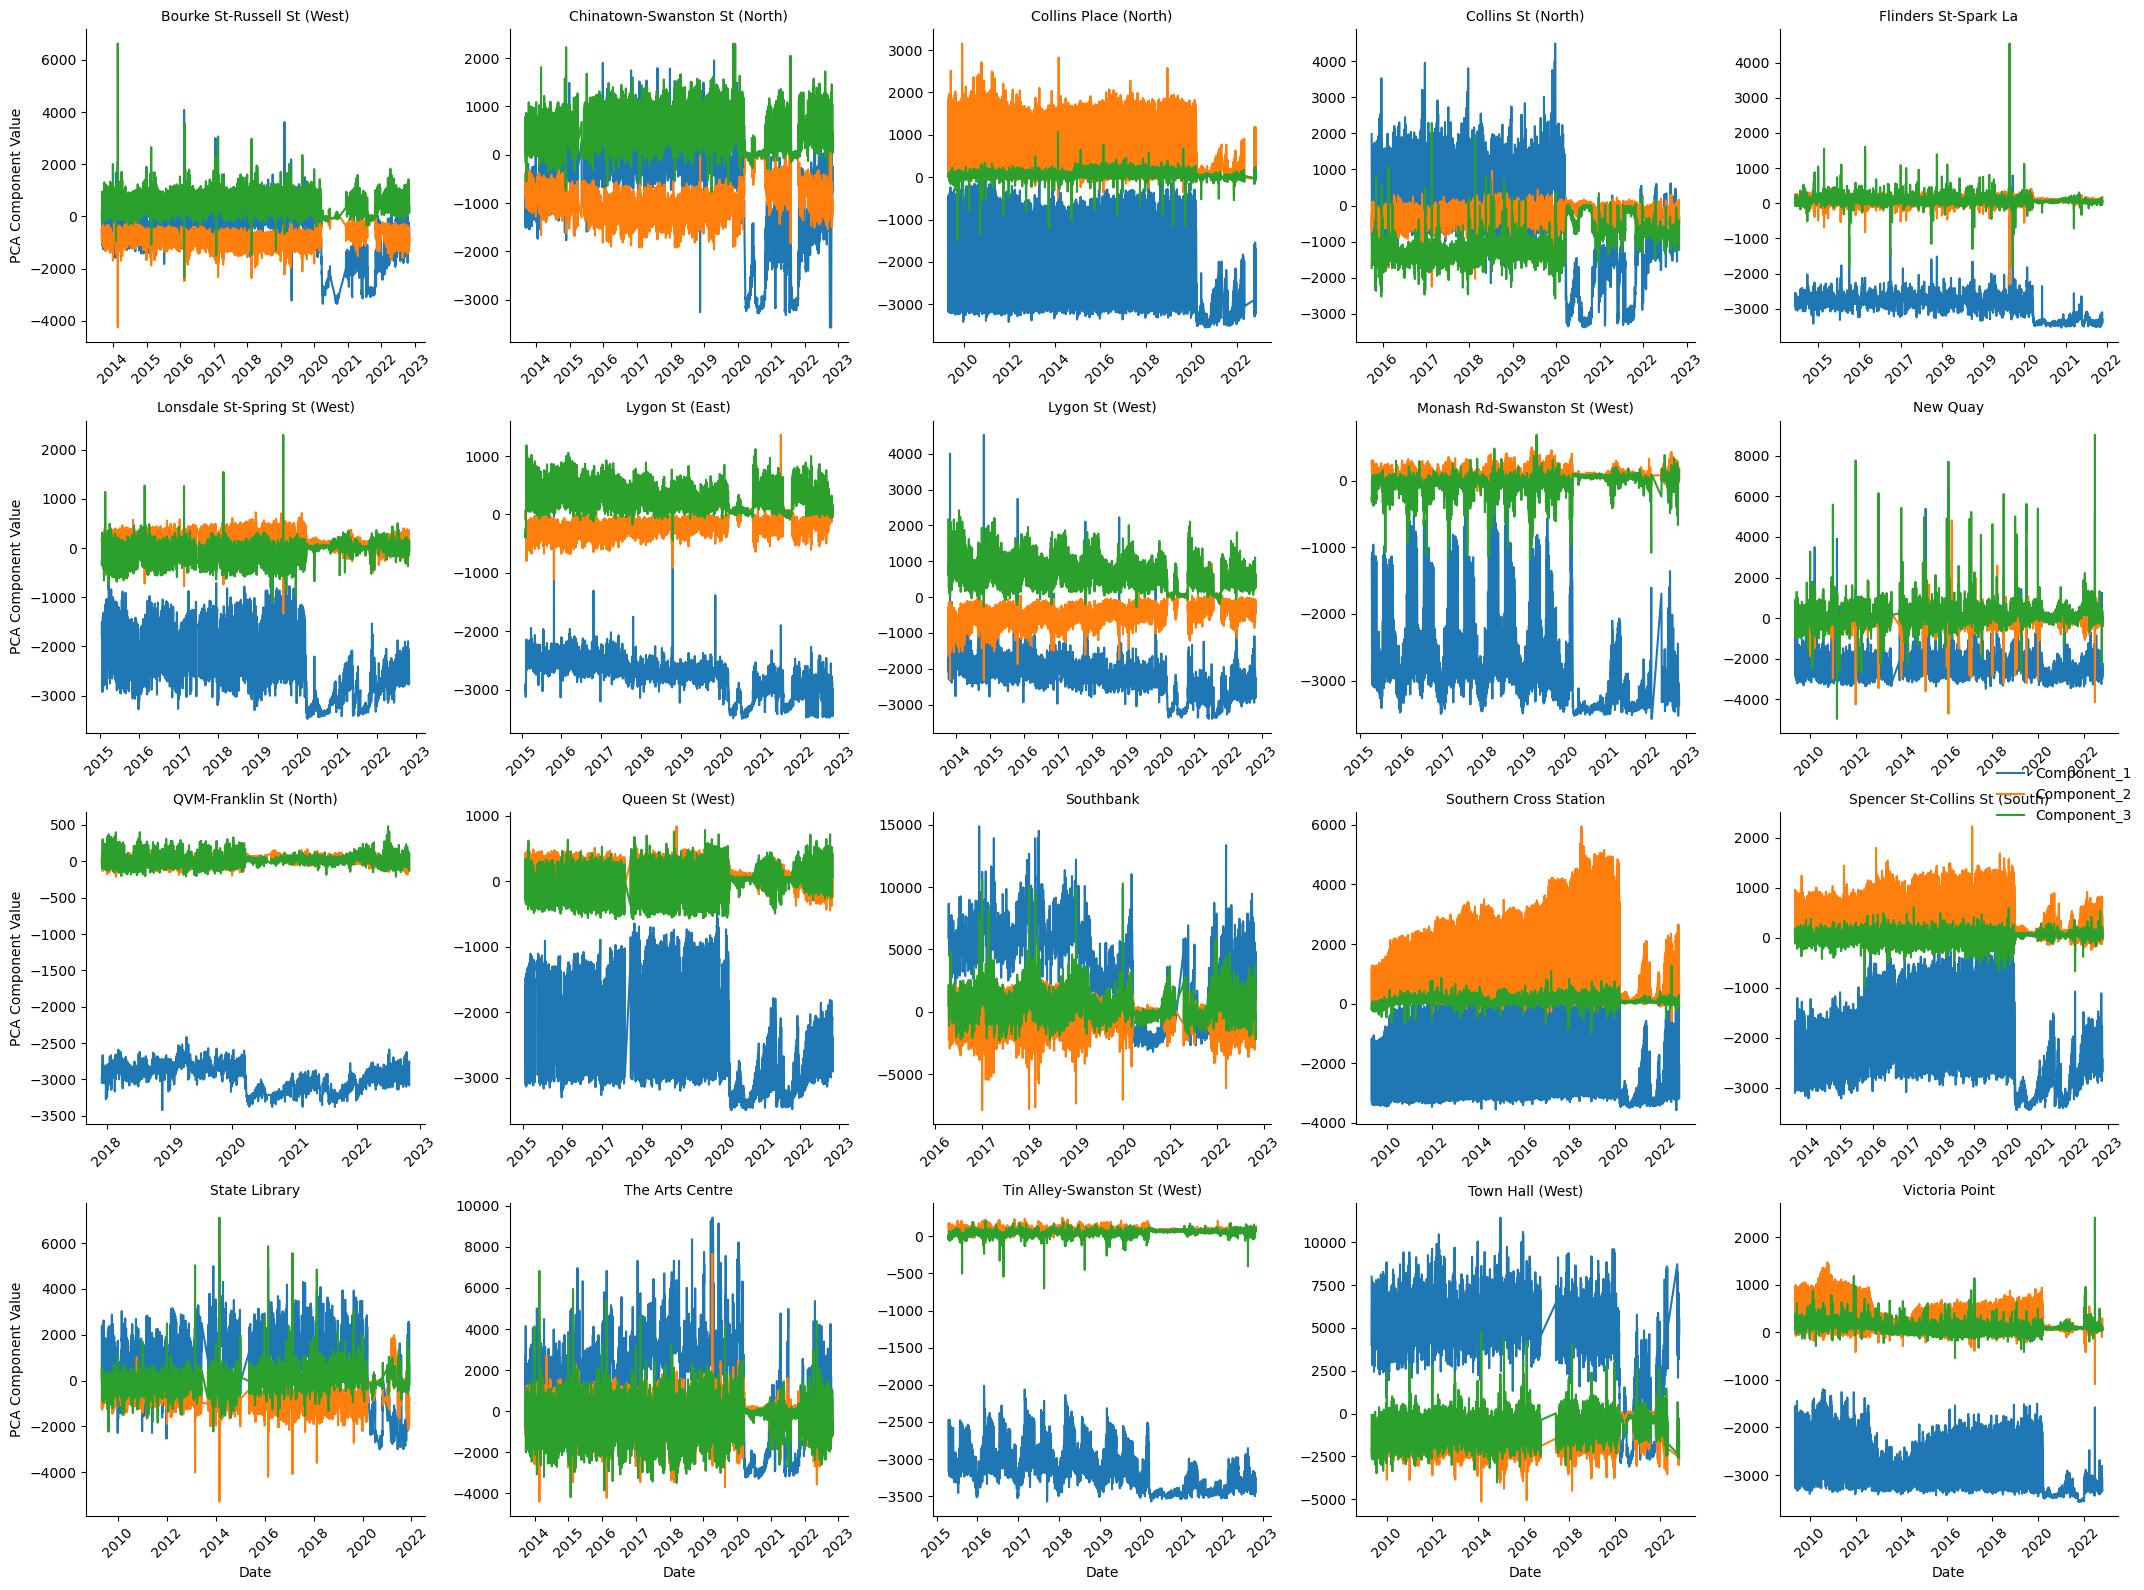

In [9]:
#sns.set(rc={'figure.figsize':(10,5)})

g = sns.FacetGrid(df_pcadays, col="Location", col_wrap=5, height=4, sharey=False, sharex=False)
g.map_dataframe(sns.lineplot, x='Date', y='Value', hue='Component')
g.add_legend()
g.set_axis_labels("Date", "PCA Component Value")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [10]:
def get_pca_from_pipeline(pipeline):
    for step in pipeline.steps:
        if isinstance(step[1], PCA):
            return step[1]
    return None
    

pipeline1 = Pipeline([
    ('pca', PCA())  
])

pipeline1.fit(week_array1)

Pipeline(steps=[('pca', PCA())])

In [11]:
fitted = pipeline1.transform(week_array2)
df_pcaweeks = pd.DataFrame(fitted[:, :3], columns=[f'Component_{i+1}' for i in range(3)])
df_pcaweeks['Location'] = week_labels2
df_pcaweeks['Date'] = week_dates2
df_pcaweeks = df_pcaweeks.melt(id_vars=['Date', 'Location'], var_name='Component', value_name='Value')
#df_pcaweeks = df_pcaweeks[df_pcaweeks['Location'].isin(sites_complete)]

In [12]:
all_dates = pd.date_range(start=df_pcaweeks['Date'].min(), end=df_pcaweeks['Date'].max(), freq='W-MON')
locations = df_pcaweeks['Location'].unique()
components = df_pcaweeks['Component'].unique()

# Create a complete multi-index (Date, Location, Component)
multi_index = pd.MultiIndex.from_product([all_dates, locations, components], names=['Date', 'Location', 'Component'])

# Reindex the dataframe with the new multi-index
df_filled = df_pcaweeks.set_index(['Date', 'Location', 'Component']).reindex(multi_index)

# Reset the index to make 'Date', 'Location', and 'Component' columns again
df_filled = df_filled.reset_index()

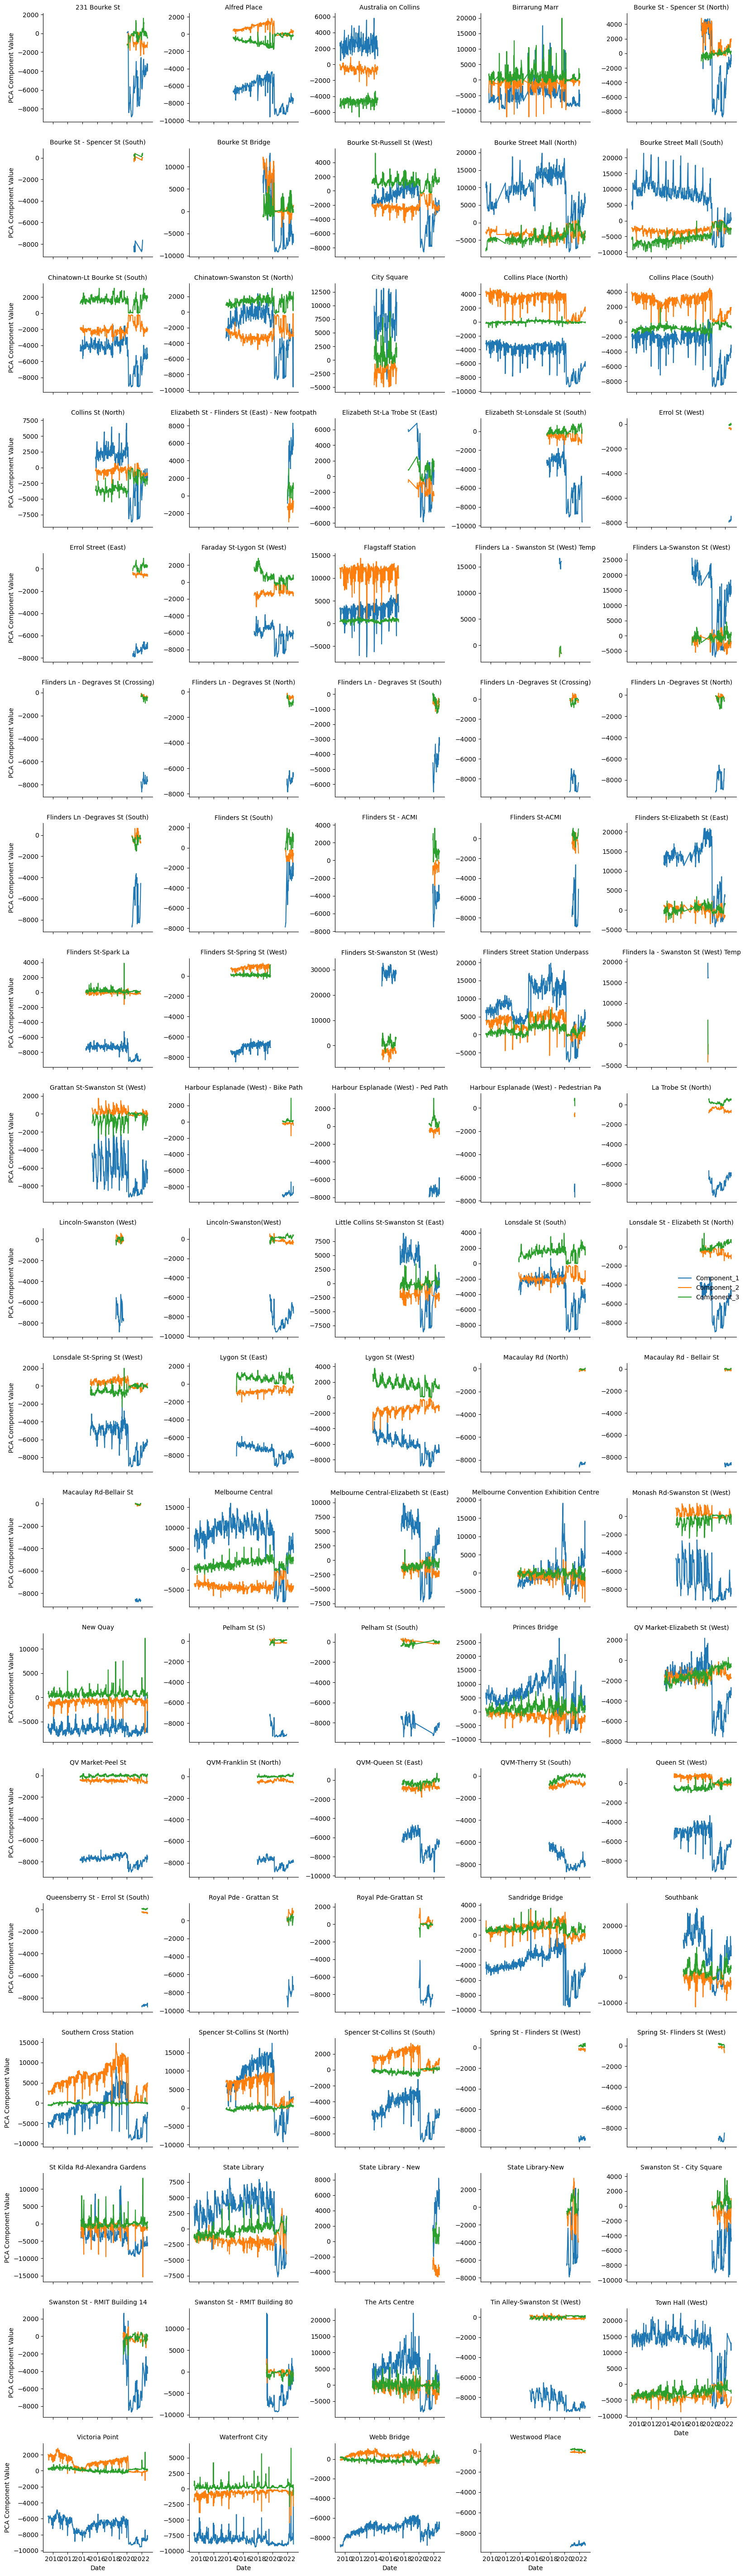

In [13]:
g = sns.FacetGrid(df_filled, col="Location", col_wrap=5, sharey=False, sharex=True,legend_out=True)
g.map_dataframe(sns.lineplot, x='Date', y='Value', hue='Component')
g.add_legend()
g.set_axis_labels("Date", "PCA Component Value")
g.set_titles("{col_name}")
#for ax in g.axes.flatten():
#    for label in ax.get_xticklabels():
#        label.set_rotation(45)

plt.tight_layout()
plt.show()

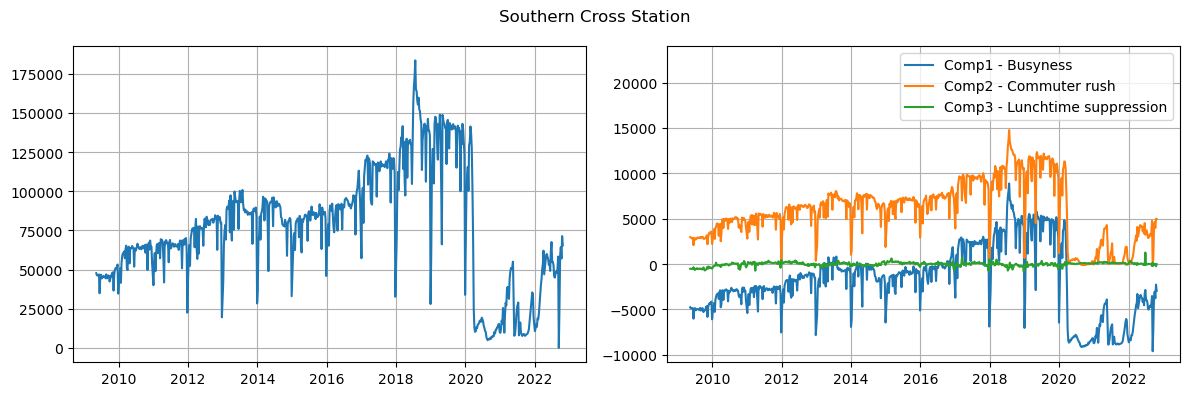

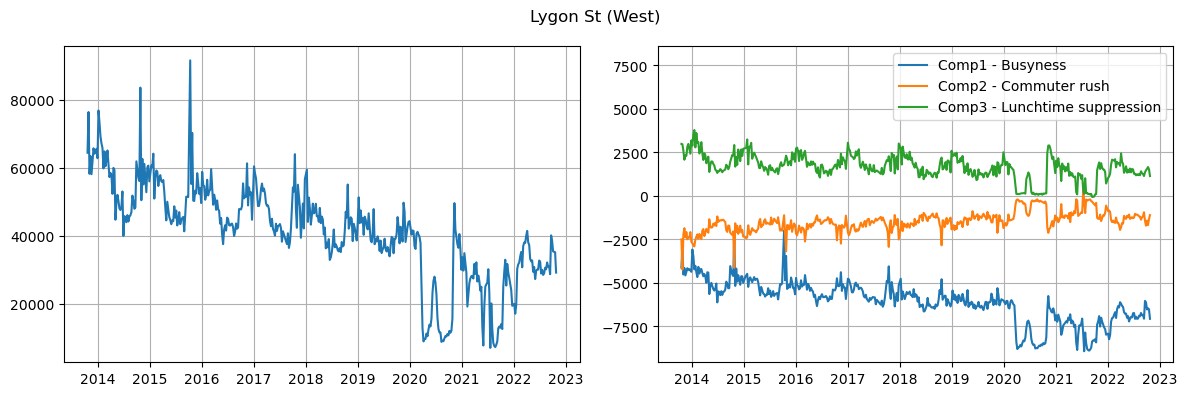

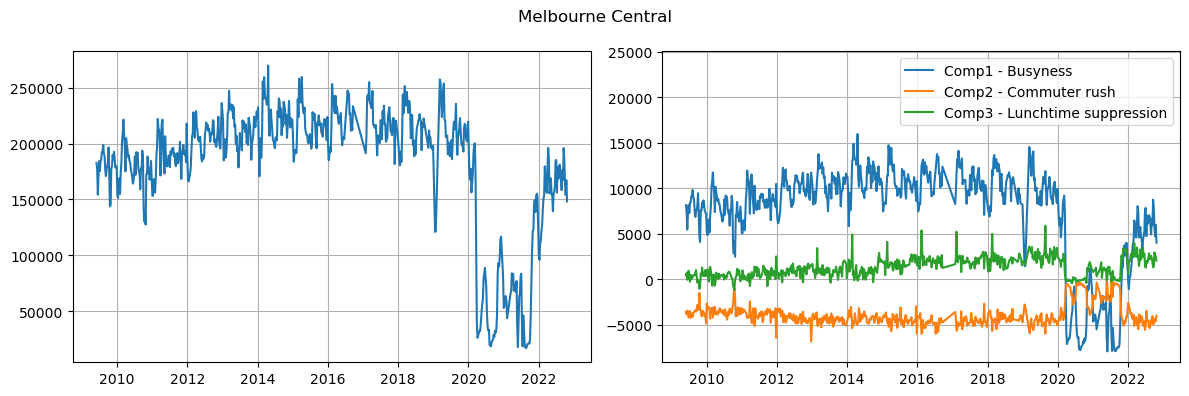

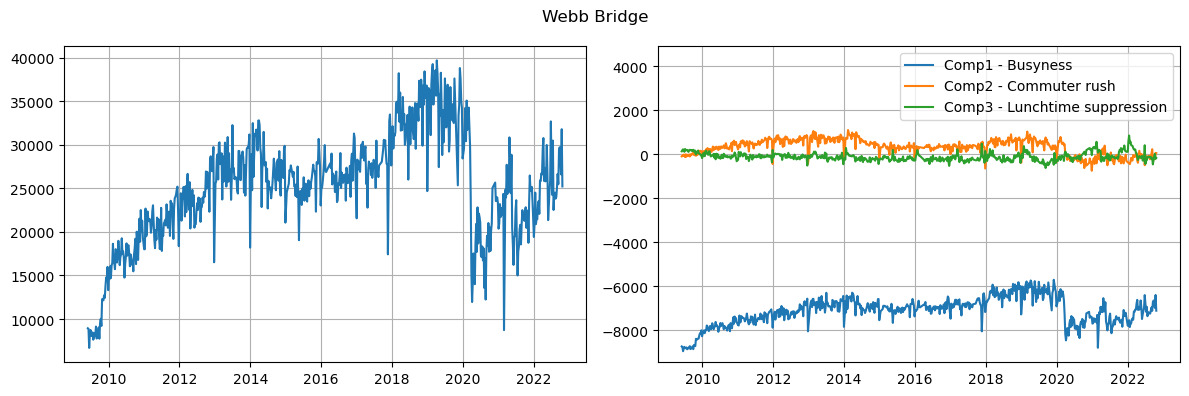

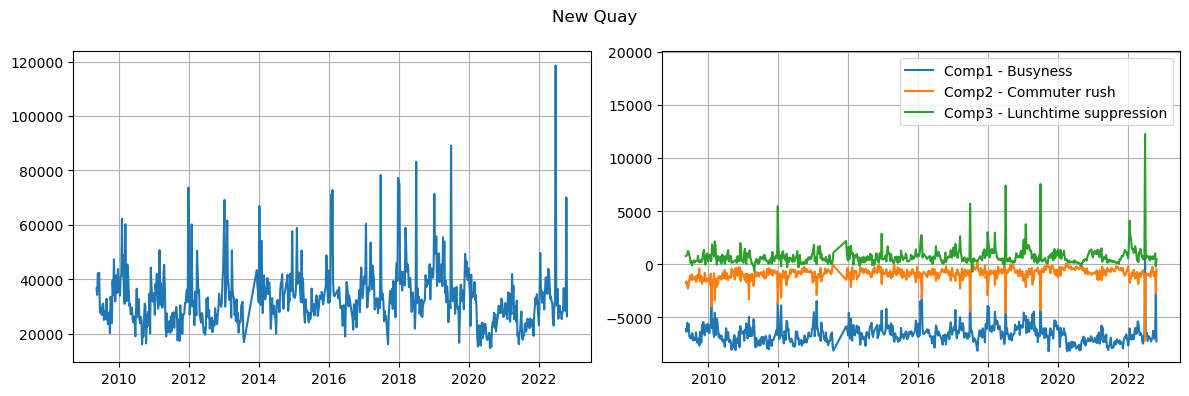

In [14]:
labels = np.unique(week_labels2)

descs = {1:'Busyness',
         2:'Commuter rush',
         3:'Lunchtime suppression'}

def plotSideBySide(loc,axs):
    axs[0].plot( week_dates2[week_labels2==loc],week_array2[week_labels2==loc,:].sum(axis=1) )
    for i in range(1,4):
        d = df_pcaweeks.loc[(df_pcaweeks['Location'] == loc) & (df_pcaweeks['Component'] == f'Component_{i}')]
        axs[1].plot( d['Date'].values,
                     d['Value'].values,label=f'Comp{i} - {descs[i]}' )

    ymin, ymax = axs[1].get_ylim()  # Get the current y-axis limits
    new_ymax = ymax + (ymax - ymin) * 0.3
    axs[1].set_ylim(ymin,new_ymax)
    axs[1].legend(loc='upper right')
    axs[1].grid()

    axs[0].grid()



locs = ['Southern Cross Station','Lygon St (West)','Melbourne Central','Webb Bridge','New Quay']
for loc in locs:
    fig,axs = plt.subplots(1,2,figsize=(12,4))
    plotSideBySide(loc,axs)
    plt.suptitle(loc)
    plt.tight_layout()
    plt.savefig(f"Plots/PCA/VisTSWeeks/{loc}.pdf")